In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 12:58:15.635582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 12:58:17.188615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 14900
end_idx = 15010
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(110, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(110, 96, 7)
(73920,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(110, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(110, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 12:58:26.862653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:88:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 12:58:29.840588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step
CPU time: 2647.798875908833 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

4/4 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.21804138 0.89378895 0.56785642 ... 0.68124085 0.95413686 0.66310563]
Fitness value of the best solution = 0.0025957395005566106


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

4/4 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


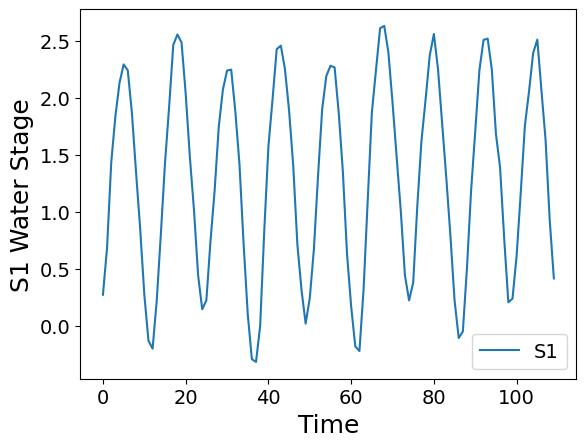

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low19.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.218041,0.893789,0.567856,0.042569,0.588872,0.631766,0.307291,0.411895,0.579338,0.451942,...,0.979614,0.158993,0.207933,0.571711,0.940073,0.613146,0.766557,0.957562,0.065801,0.592868
1,0.236836,0.495190,0.987229,0.510673,0.491573,0.957504,0.461488,0.466829,0.783440,0.642466,...,0.327449,0.478296,0.743209,0.865140,0.538497,0.294160,0.263304,0.108713,0.152978,0.722915
2,0.910047,0.332830,0.479601,0.520475,0.172704,0.832092,0.097472,0.011364,0.431358,0.178214,...,0.058359,0.437087,0.640184,0.832412,0.693771,0.859892,0.089491,0.775123,0.267199,0.141859
3,0.241529,0.544560,0.495705,0.368655,0.794908,0.537734,0.687845,0.755634,0.683236,0.902703,...,0.315827,0.624170,0.395009,0.281062,0.217511,0.271065,0.459759,0.528136,0.502730,0.501372
4,0.296827,0.651793,0.037584,0.130069,0.762273,0.501317,0.910915,0.821506,0.985225,0.752173,...,0.867015,0.694360,0.422269,0.809086,0.172829,0.896073,0.367687,0.052550,0.856120,0.909456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.924217,0.851943,0.146891,0.805112,0.530551,0.354571,0.344373,0.282764,0.913580,0.026786,...,0.333584,0.860328,0.449844,0.837238,0.806694,0.357929,0.761148,0.657461,0.289834,0.448387
106,0.397242,0.927209,0.790547,0.603243,0.578803,0.242215,0.077107,0.852328,0.671446,0.489761,...,0.741398,0.122619,0.032204,0.104891,0.339561,0.176958,0.288678,0.709826,0.857489,0.524635
107,0.713577,0.766351,0.164284,0.815984,0.981565,0.147516,0.121418,0.759354,0.629203,0.335804,...,0.034010,0.163655,0.720322,0.202020,0.899515,0.118323,0.200829,0.780054,0.005447,0.432188
108,0.775849,0.182978,0.143813,0.657056,0.898085,0.328402,0.622719,0.400699,0.078163,0.580214,...,0.083027,0.773559,0.009913,0.366645,0.105037,0.210995,0.184748,0.944841,0.063330,0.258286


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low19.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.272524,0.526640,0.339120,0.328879,0.792740,0.947447,0.723724,0.778747,1.385873,1.217135,...,1.702901,1.639122,0.961077,1.058090,1.154161,1.078136,0.636478,0.757013,0.866162,0.809278
1,0.688291,0.533708,0.655373,0.651826,1.501167,1.343666,1.450043,1.594745,1.781161,1.707132,...,1.146434,1.118567,0.575515,0.783014,0.846912,0.796353,0.178557,0.466824,0.407126,0.355600
2,1.429294,1.263531,1.448548,1.546108,1.778732,1.870943,1.676617,1.803892,2.089535,1.968478,...,0.829282,0.755271,0.206241,0.122901,0.381379,0.309433,0.322952,0.457307,0.418863,0.395407
3,1.834091,2.062917,1.820279,1.921827,2.065015,1.927854,1.936113,2.103057,2.430863,2.273994,...,0.486456,0.369797,0.354363,0.471690,0.527242,0.486237,0.633637,0.697712,0.691985,0.719299
4,2.128694,2.388884,2.176043,2.310797,2.278351,2.207432,2.231849,2.348227,2.263340,2.432368,...,0.474501,0.422515,0.647079,0.615650,0.736634,0.793515,1.111410,1.310784,1.244944,1.309867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2.508335,2.697740,2.591159,2.704089,2.251780,2.124194,2.242816,2.364235,1.728589,1.807415,...,1.250045,1.270653,1.656953,1.874555,1.653831,1.774489,2.103672,2.381712,2.177533,2.293264
106,2.062243,2.063452,2.125973,2.143871,1.624948,1.633984,1.713354,1.773478,1.040570,0.877373,...,1.637452,1.728010,2.194037,2.484210,2.199261,2.303076,2.420611,2.446740,2.446269,2.578752
107,1.628870,1.595372,1.811563,1.767952,1.067245,0.872960,1.178382,1.179376,0.467331,0.455351,...,2.239194,2.286838,2.314778,2.716396,2.369468,2.435241,2.377409,2.417079,2.507660,2.583139
108,0.926171,0.710662,1.004414,1.014061,0.558397,0.236834,0.618283,0.608068,-0.054392,0.010348,...,2.323011,2.491114,2.379891,2.307107,2.405004,2.546341,2.061056,2.110576,2.118072,2.289669


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 544, areas: 76.96778915561299


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

4/4 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 1012, areas: 210.15971092152176
